# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true, y_pred):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    nfpr, ntpr, thresholds = roc_curve(y_true, ns_probs)
    ns_auc = auc(nfpr, ntpr)
    lr_auc = auc(fpr, tpr)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    print('Logistic: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='0.5')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y_p, y, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder = 'rboa\\'
X_train = np.load(folder+'X_train.npy')
y_train = np.load(folder+'y_train.npy')

clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=7, max_features='log2', max_depth=20, verbose=2, n_jobs=1)

In [4]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.1s remaining:    0.0s


building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 132.2min finished


RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=7,
                       min_samples_split=3, n_estimators=400, n_jobs=1,
                       verbose=2)

# Test Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished


Best Threshold=0.598023
Logistic: ROC AUC=1.000
Logistic: ROC AUC=0.500


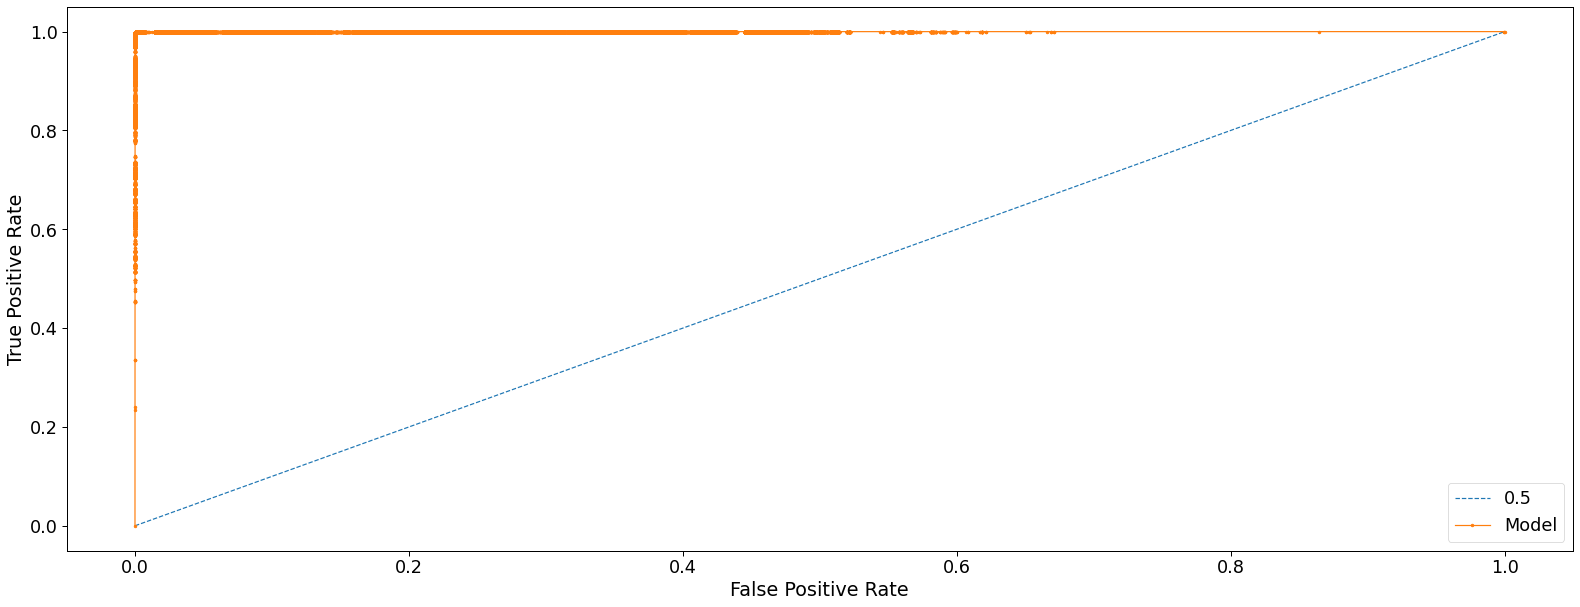

[[1277053    1202]
 [    207 1278048]]


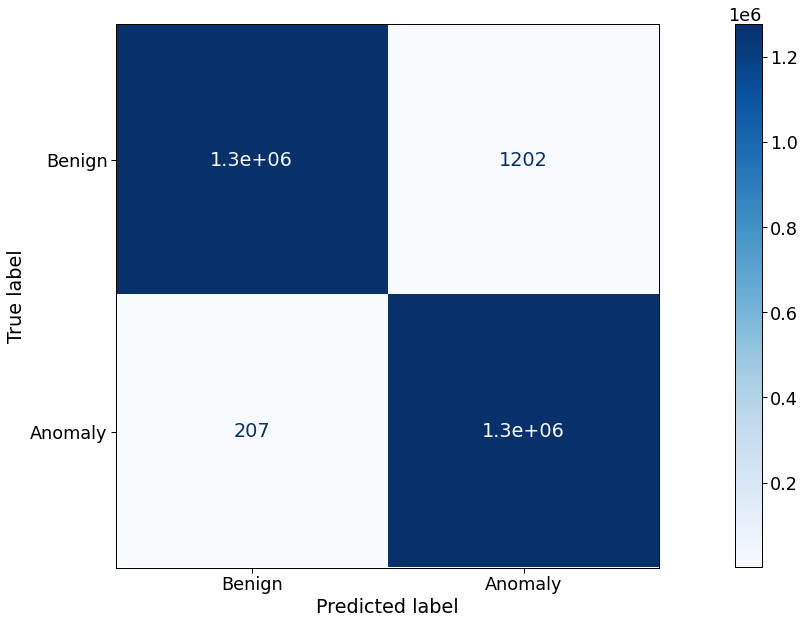

accuracy:  0.9994488580134636
f1:  0.999449072435831
precision:  0.9990603869454758
recall:  0.99983806048089
mcc:  0.9988980186502414


In [5]:
X_1 = np.load(folder+'X_test.npy')
y_1 = np.load(folder+'y_test.npy')

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)

# Full Test Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  8.0min finished


Best Threshold=0.005837
Logistic: ROC AUC=0.892
Logistic: ROC AUC=0.500


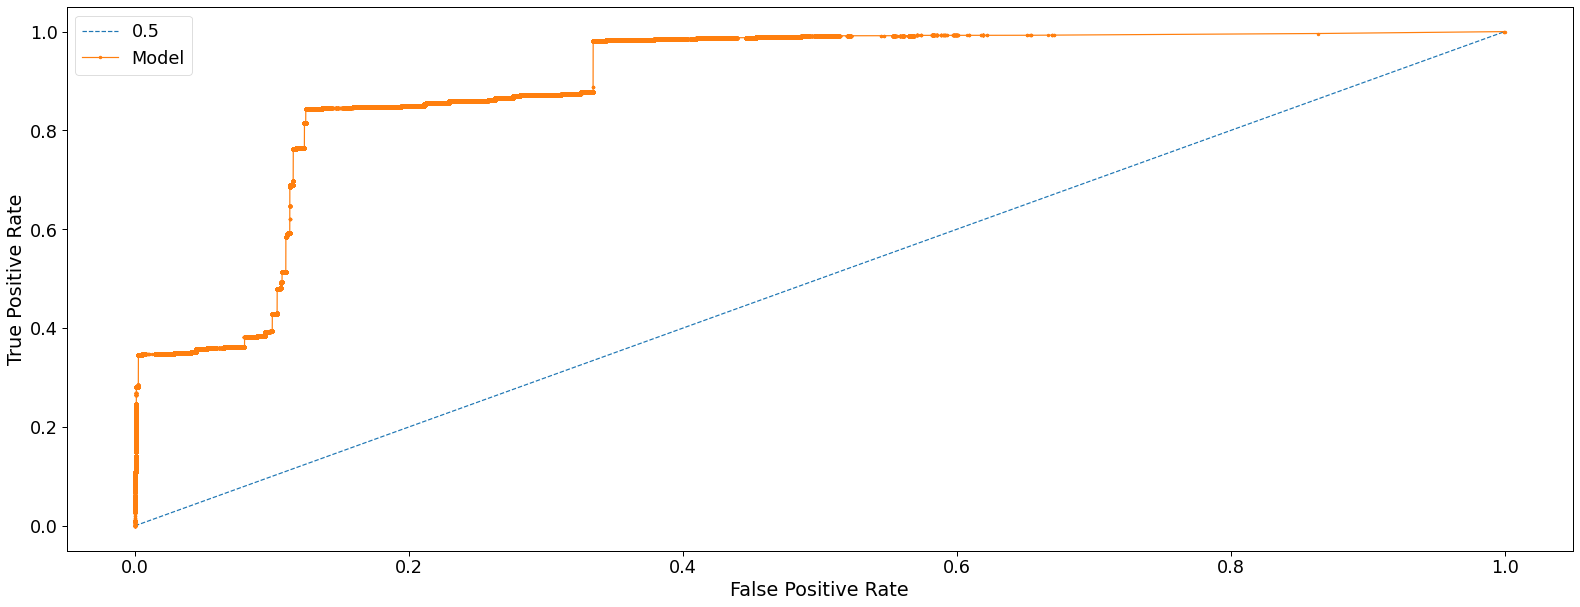

[[10361323     9423]
 [ 1679800   544704]]


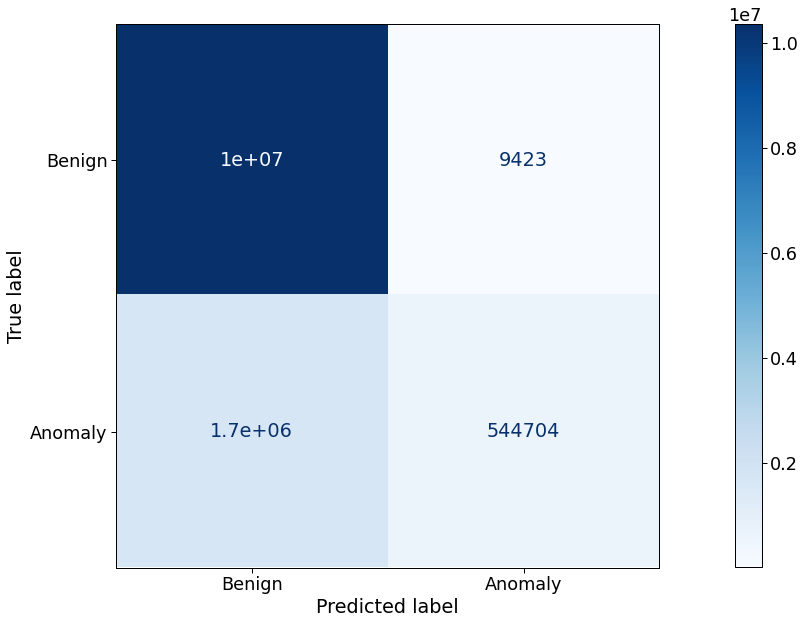

accuracy:  0.8658841229828705
f1:  0.392066452868337
precision:  0.9829948730164746
recall:  0.2448653722357883
mcc:  0.45362428495287366
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          0                          6
                          1                       2088
Brute Force -XSS          0                          5
                          1                        890
DDOS attack-HOIC          1                    1080858
DDoS attacks-LOIC-HTTP    1                     280337
DoS attacks-GoldenEye     0                      26729
                          1                        994
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                      21912
                          1                     

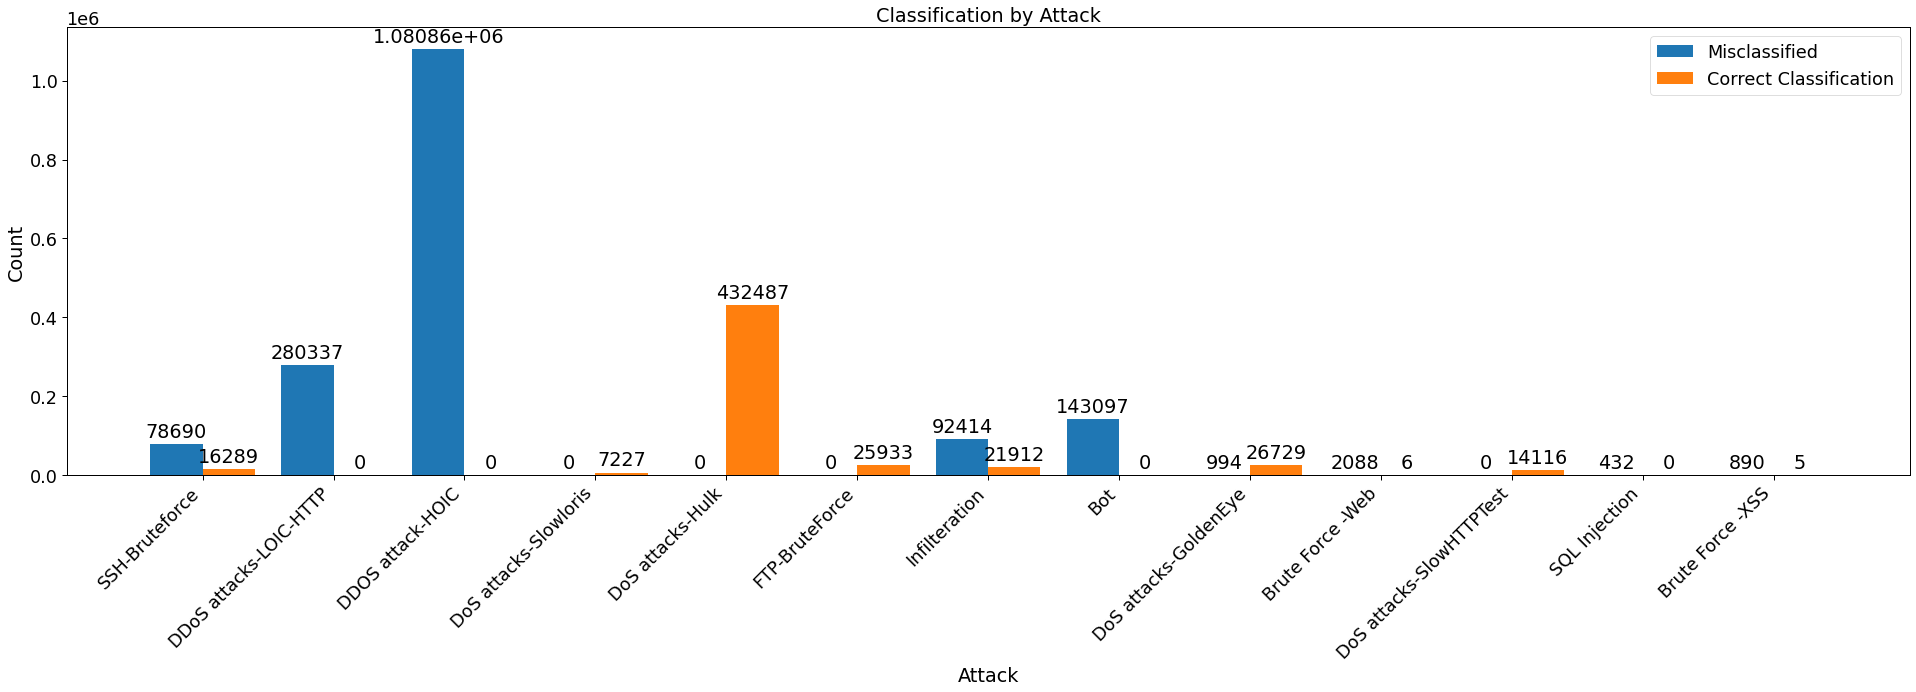

In [6]:
X_1 = np.load(folder+'X_1.npy')
y_1 = np.load(folder+'y_1.npy')
a_1 = np.load(folder+'a_1.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)

# Full Test Set with Threshold

Best Threshold=0.005837
[[9078069 1292677]
 [ 412689 1811815]]


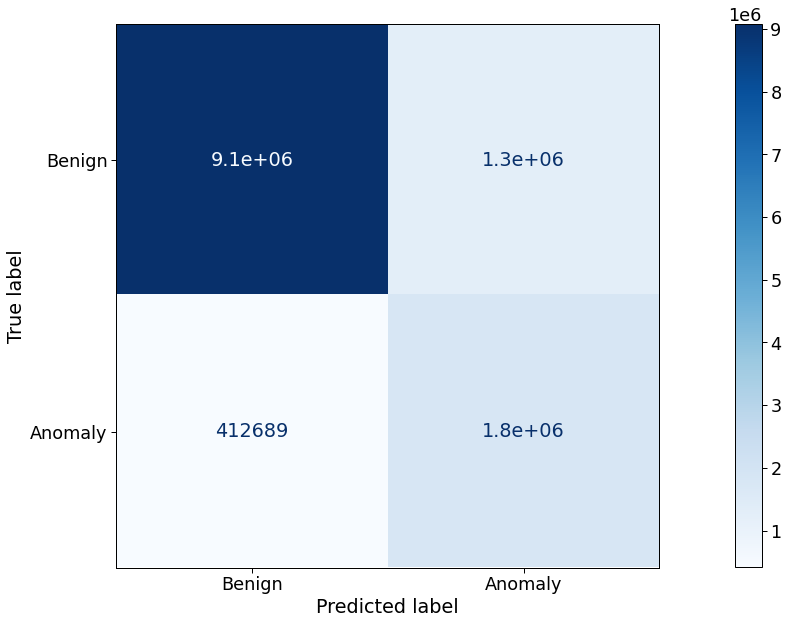

accuracy:  0.8646024493360592
f1:  0.6799836216803316
precision:  0.58361078076542
recall:  0.8144804414826856
mcc:  0.6104083171268845
attack                    misclassification
Bot                       0                    143097
Brute Force -Web          0                      1617
                          1                       477
Brute Force -XSS          0                       685
                          1                       210
DDOS attack-HOIC          0                    932217
                          1                    148641
DDoS attacks-LOIC-HTTP    0                     87579
                          1                    192758
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432487
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      7227
FTP-BruteForce            0                     25933
Infilteration             0                     43817
          

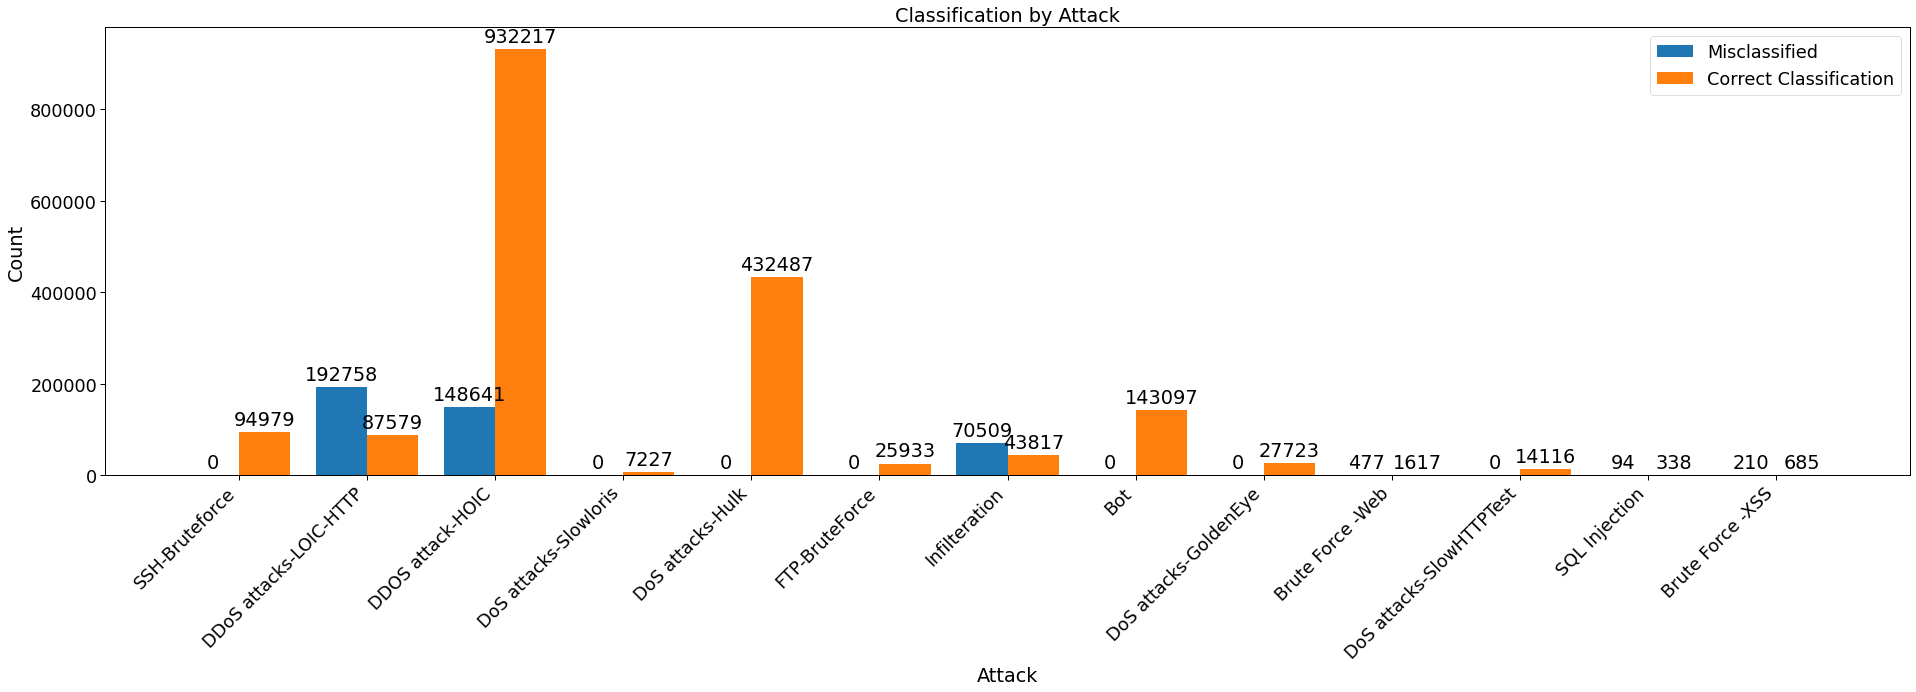

In [7]:
print('Best Threshold=%f' % (best_thresh))
y_pred2 = np.where(y_pred_o > best_thresh, 1, 0)
test_report(y_1 ,y_pred2)
attack_report(y_pred2, y_1, a_1)

# Test Set AR

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  7.4min finished


Best Threshold=0.196636
Logistic: ROC AUC=0.953
Logistic: ROC AUC=0.500


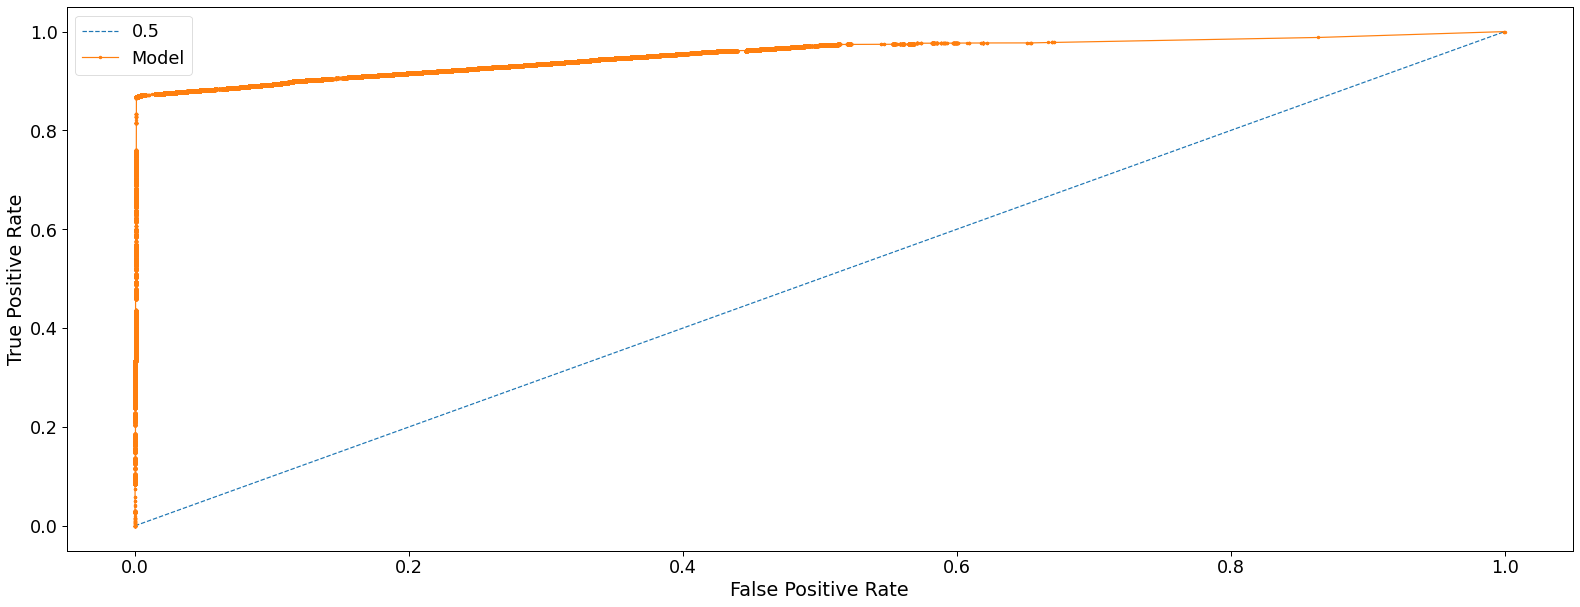

[[10361323     9423]
 [  175508   544704]]


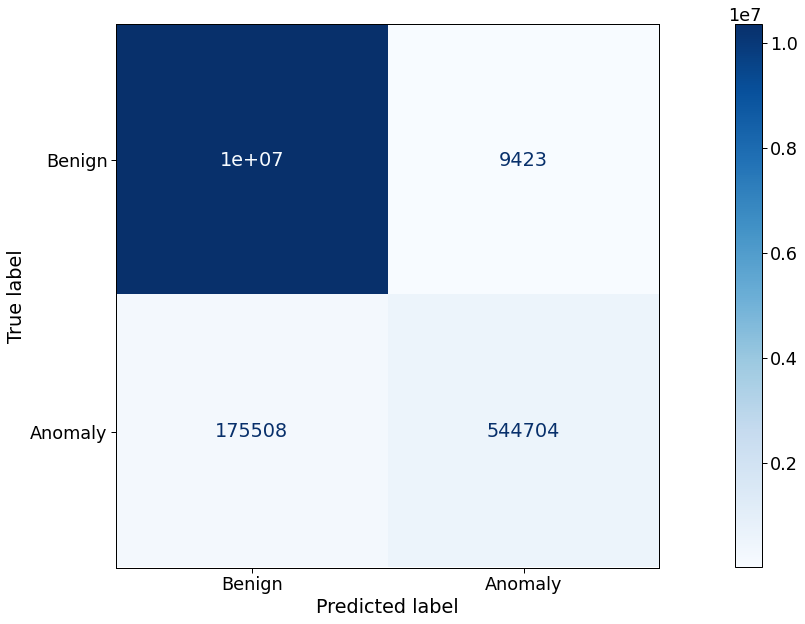

accuracy:  0.9833259669723752
f1:  0.8548808441082004
precision:  0.9829948730164746
recall:  0.7563106418665615
mcc:  0.8543850862937366
attack                    misclassification
Brute Force -Web          0                         6
                          1                      2088
Brute Force -XSS          0                         5
                          1                       890
DoS attacks-GoldenEye     0                     26729
                          1                       994
DoS attacks-Hulk          0                    432487
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      7227
FTP-BruteForce            0                     25933
Infilteration             0                     21912
                          1                     92414
SQL Injection             1                       432
SSH-Bruteforce            0                     16289
                          1                     78690
dtype: i

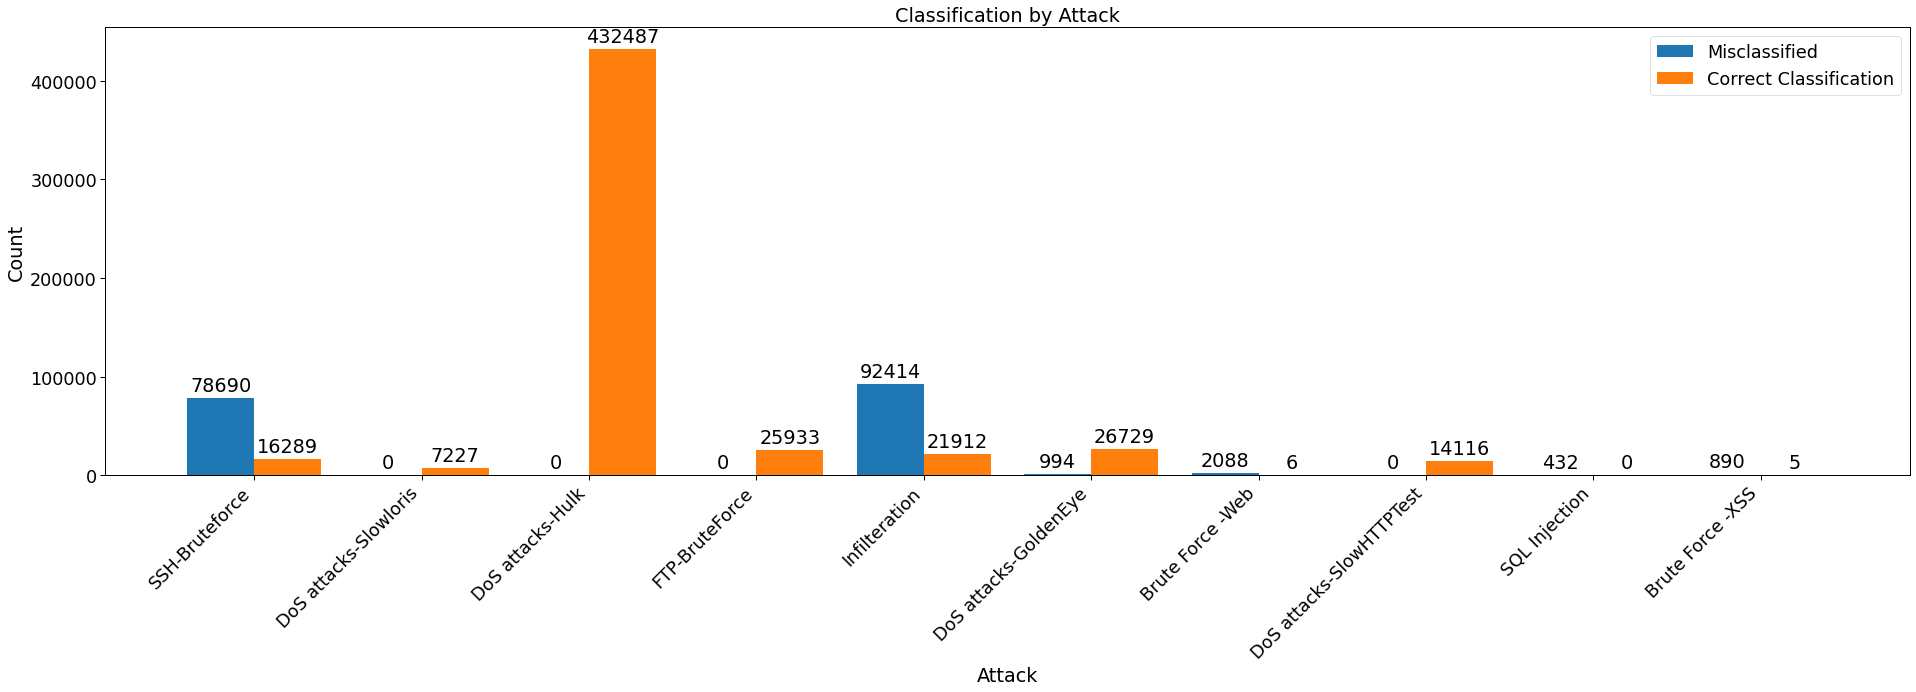

In [8]:
X_1 = np.load(folder+'X_1_ar.npy')
y_1 = np.load(folder+'y_1_ar.npy')
a_1 = np.load(folder+'a_1_ar.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]

fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)

In [9]:
import pickle
saveModel = 'RF_Models\\'
filename = 'rboa-e7.pkl'
pickle.dump(clf, open(saveModel+filename, 'wb'))